In [1]:
#loading minimal set of libraries
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point  #that's annoying! Cannot load whole cartopy module to get 
#access to all methods/attributes - must add methods specifically like this?
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#will test how seaborn formatting affects cartopy mapping later
#import seaborn as sns; sns.set() #need to use sns.set() to turn on seaborn formatting in new version of seaborn

In [2]:
#loading a test dataset - GPCP from NOAA THREDDS server
gpcpfile='https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc'
ds_gpcp=xr.open_dataset(gpcpfile)


In [3]:
#take time-mean of dataset from beginning until end of 2016 (b/c full year of 2017 not up yet)
#print(ds_gpcp['time'].isel(time=-1)) #prints last time

#take annual means first so can easily exclude 2017, then select 1979-2016, then mean over those years
gpcpclimo=ds_gpcp.groupby('time.year').mean('time').sel(year=slice(1979,2016)).mean('year')

#Is it more efficient to do all those selections and means over a couple steps instead of in one step?  
#Don't think it matters b/c the computation for xarray is only brought into memory when actually needed. Could timeit to figure out.

lon=ds_gpcp['lon']
lat=ds_gpcp['lat']

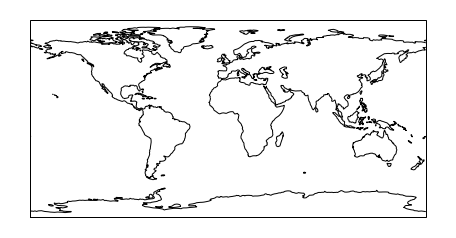

In [4]:
#let's figure out how to plot in cartopy...  
#first let's make a simple map with coastlines (as in online example)
f=plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree()) #switching up the projection
#ax=plt.axes(projection=ccrs.Robinson(central_longitude=-55)) #playing with where center is

ax.coastlines()

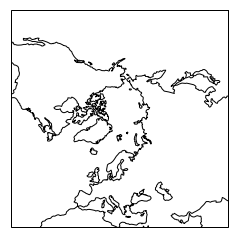

In [5]:
#will need north pole centered maps
f=plt.figure(figsize=(10,4))

ax=plt.axes(projection=ccrs.Stereographic(central_latitude=90,central_longitude=20)) 
ax.set_extent([-180,180,30,90],crs=ccrs.PlateCarree()) 
#confusing: why is the set extent done with PlateCarree and not Stereographic? 
#It's using the ax object that is already in Stereographic coordinates. So why does ax.set_extent() fail when set 
#ccrs=Stereographic()? Is it b/c the extents are in lon,lat space that isn't yet transformed to map coordinates? 

#cannot figure out how to get the map to be circular rather than square... this'll do for now. At least it's plotting.
ax.coastlines()

(72, 145) (145,) (144,) (72,)


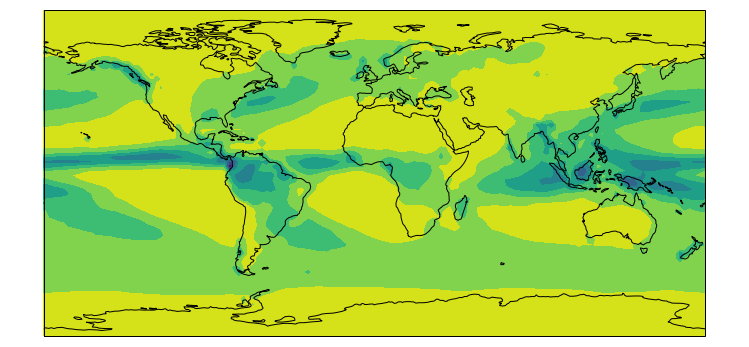

In [6]:
#now let's put something on the blank map

f=plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree()) 

#plt.contourf(lon,lat,gpcpclimo['precip'],transform=cartopy.crs.PlateCarree(),cmap=plt.cm.viridis_r) 

#let's get rid of the annoying gap at the Prime Meridian by adding a cyclic value
#print(help(cartopy))
dataout,lonout=add_cyclic_point(gpcpclimo['precip'].values,coord=lon.values) 
#like basemap, cartopy also doesn't play nice with xarray, 
#must convert xarray DataArray objects to numpy arrays using .values method

print(np.shape(dataout),np.shape(lonout),np.shape(lon.values),np.shape(lat.values))
plt.contourf(lonout,lat.values,dataout,transform=ccrs.PlateCarree(),cmap=plt.cm.viridis_r) 

ax.coastlines()

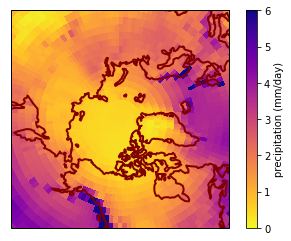

In [15]:
#I assume pcolor with cartopy is just as straightforward?

#comment this line out if do not have seaborn imported - I generally like adding the default seaborn ticks
#sns.set_style('ticks')

f=plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=90,central_longitude=-120)) 

#let's get rid of the annoying non-cyclic gap at the Prime Meridian
dataout,lonout=add_cyclic_point(gpcpclimo['precip'].values,coord=lon.values) 
#doesn't play nice with xarray, must convert xr.DataArrays to nump arrays

#Note that the precip without the added cyclic value is used in the following line.
#This is because pcolor will plot correctly with x(i),y(j) corresponding to the center of array(i,j) if 
#x(i),y(j) correspond to the corners of the grids. len(x) and len(y) must be one greater than the corresponding 
#axis lengths of the array to be plotted. Otherwise, like Matlab, for a,b = np.shape(values), if a==len(x) and 
#b==len(y), pcolor will use x,y at the left hand corners and the values will be plotted with an offset by half a grid 
#cell from where they should be. This means we need to adjust the manually adjust lats to correspond to corners of the
#cells. This annoying offsetting is not an issue with contour/contourf, which is why I use those more than 
#pcolor/pcolormesh.

#latitude "correction" by adding one latitude to North Pole and subtracting half a grid cell length
#print(lat.values) #check if lat evenly gridded - it is.
latgridlen=(lat.values[-1]-lat.values[-2])
lat_corners=np.empty(len(lat.values)+1)
lat_corners[0:-1]=lat.values #python not inclusive of second value in a slice #-1 = last index, -2 = second to last, etc.
lat_corners[-1]=lat.values[-1]+latgridlen
lat_corners=lat_corners-latgridlen/2
#if use lat.values with pcolor without this, you will get an annoying white circle at NP because lat not 
#corresponding to all corners, only to left hand corners

CS=plt.pcolor(lonout,lat_corners,gpcpclimo['precip'].values,vmin=0,vmax=6,transform=ccrs.PlateCarree()\
              ,cmap=plt.cm.plasma_r)  
#again, why does transform = PlateCarree if ax object in Stereographic?  
#Doesn't work if set transform to Stereographic. This doesn't make sense to me... but it only works this way. whatever.

ax.set_extent([-180,180,50,90],crs=ccrs.PlateCarree())  #cropping the map
ax.coastlines(color='maroon',linewidth=2) # for some reason, it's a color that comes to mind.
CB=plt.colorbar(CS) #colorbar - if not including the CS in the (), this will still work here 
#since only have one thing plotted - but this guarantees it when overlaying multiple types of plotting
CB.set_label('precipitation (mm/day)')

plt.savefig('testcartopy_figure.png') #saves to current directory

#Note after talking with Luke: cartopy works great for global maps like these but is HORRIBLE for plotting 
#when the data is only for a limited region. It leaves annoying white space that is difficult to remove using 
#ax.set_extent(). The WRF-python module uses cartopy in its plotting routine and somehow has gotten around this issue
#but how it does this is buried deep in a number of inheritances and methods 

TopologyException: side location conflict at -1.0785555591507572e-09 -9020047.8480736464
TopologyException: side location conflict at -1.0632133748100633e-09 -9020047.8480736464
TopologyException: side location conflict at -1.0478711904693701e-09 -9020047.8480736464


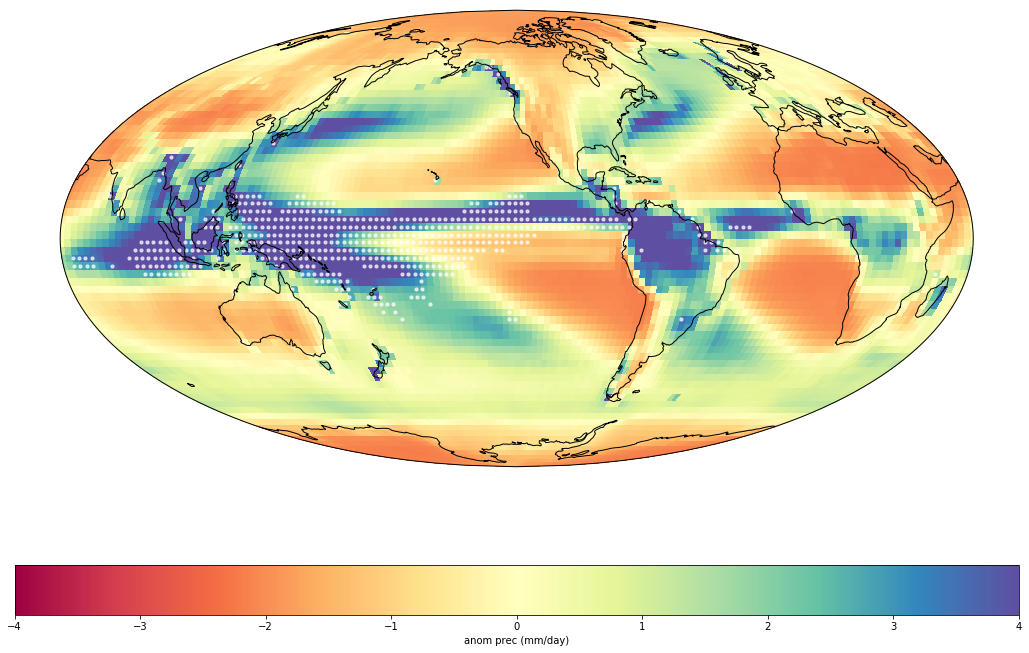

In [51]:
#Let's see if we can easily put markers on top of a pcolor (as one might for indicating significance)

#pick a new projection for fun - here's the list of all of them: 
#http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
f=plt.figure(figsize=(18,12)) #make it big
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=-123)) 

CS=plt.pcolor(lonout,lat_corners,gpcpclimo['precip']-gpcpclimo['precip'].mean(),vmin=-4,vmax=4,\
              transform=ccrs.PlateCarree(),cmap=plt.cm.Spectral)  #cool, can leave array to be plotted in xarray format
#Ok. I think I get it after playing with this. The axis object sets up the projection you want to see.
#In the plotting line, the transform indicates the projection that lon and lat are already in.

#construct something to scatter - how about where annual mean precip time series has standard deviation > 1 mm/day 
precip_std=ds_gpcp['precip'].groupby('time.year').mean('time').sel(year=slice(1979,2016)).std('year')

lons,lats=np.meshgrid(lon,lat)
lons[precip_std.values<1]=np.nan #select only where stdev <1, set to nan
lats[precip_std.values<1]=np.nan
plt.scatter(lons,lats,color='white',s=10,alpha=0.7,transform=ccrs.PlateCarree())

ax.coastlines()
CB=plt.colorbar(CS,orientation='horizontal')
CB.set_label('anom prec (mm/day)')
#colorbar is really ugly. can use GridSpec to give it better proportions

#for available matplotlib colormaps, see: https://matplotlib.org/examples/color/colormaps_reference.html
#seaborn provides interface for those plus more: https://seaborn.pydata.org/tutorial/color_palettes.html

#At some point (this spring?), I want to write a quick script to load NCL color tables, probably will pull from web 
#so it'll work on any system: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml